## Black Scholes Model and Delta Hedged Portfolio with Different Volatility Type

Reminder of BSM formula of a plain vanilla call otion:
\begin{equation}
V = S\cdot N(d_1) - K \cdot e^{-rT}\cdot N(d_2)
\end{equation}

where:
- $\Delta = \frac{\delta V}{\delta S} = N(d_1)$
- $d_1 = \frac{\log{\frac{S}{K}}+(r+\frac{1}{2}\sigma^{2})(T-t)}{\sigma (\sqrt{T-t})}$

\
During delta hedging process, we can agree on parameters S, K, T, but should we use implied volatility or realized volatility for $\sigma$?



### Distinction between Implied Volatility and Realized Volatility

PnL of a delta hedged portfolio consisting of a long european call option and short underlying is given by:

$$dV(S,t) = \Theta dt + \frac{1}{2} \Gamma \sigma^2 S^2 dt =\Theta dt + \frac{1}{2} \Gamma \sigma^2 dS^2$$

where $dS = \pm \sigma S \sqrt t$

$\sigma$ determines the next up-down move of stock price, which is a variable whose value will be known after the move, while before that, it's a sort of guess or expectation.

- *Implied volatility $\sigma_i$* is a prediction based on currently observed market prices, which can be regarded as the market's expected value of future volatility. 

It is the value that matches the model to the market option price, i.e. the value that the unknown future stock volatility has to be in order that the model will have valued the option correctly in advance. 

- *Realized volatility $\sigma_a$* is the obvserved volatilties after time has passed, which is statistical standard deviation of returns per unit of time.

Assuming that we anticipate future volatility equals to implied volatility, then delta-hedged position will be expected to lose due to time decay during time $dt$ is $\frac{1}{2} \Gamma \sigma_i ^2 S^2 dt$, while the gain from convexity with realized (actual) volatility $\sigma_a$ is $\frac{1}{2} \Gamma \sigma_a^2 S^2 dt$, yielding net PnL which is the difference between these 2 as:


$$\text{dPnL} = \frac{1}{2} \Gamma S^2 (\sigma_a^2-\sigma_i^2)dt$$


*A delta hedged option position is a bet on variance as it is sensitive to the difference between the fixed and realized **variance** (connect to variance swap payoff).*

Consider now we construct a portfolio with long european call option and short stock with a delta $\Delta$ amount

Our PnL consists of 2 parts:
- PnL of option itself, of which we are long, which comprises interest on the premium paied at initiation; 
- PnL generated by the delta hedge, which incorporates interest we recieve on the money we sell $\Delta$ shares, as well as money we make by trading shares during $\delta t$

#### 1.1 Hedge with realized vol 
MtM PnL of a portfolio by buying option $V^i$ and hedge with $\Delta^a$ (with actual volatility) of the stock:

$$\text{MtM PnL} = dV^i - rV^idt - \Delta^adS + (r-q)\Delta^aSdt$$

While assume that option value will be corrected to actual volatility $V^a$, we then have:\
$dV^a - rV^adt - \Delta^adS + (r-q)\Delta^aSdt$

Hence the potential mark-to-market profit will be:
$$\text{profit} = dV^i-dV^a-r(V^i-V^a)dt$$

Applying Itô's lemma $dV = \Theta dt + \Delta ds + \frac{1}{2} \Gamma \sigma^2 S^2 dt$ 


The mark-to-market profit will be derived as:


$$=\Theta^i dt+ \Delta^i ds + \frac{1}{2}\Gamma^i\sigma^2S^2dt - \Delta^ads - rV^adt +(r-q)\Delta^aSdt-r(V^i-V^a)dt$$
$$=\Theta^idt + (\Delta^i - \Delta^a)(\mu Sdt + \sigma SdW) + \frac{1}{2}\Gamma^i\sigma^2S^2dt-rV^adt+(r-q)\Delta^aSdt-r(V^i-V^a)dt$$
$$=\Theta^idt +(\Delta^i - \Delta^a)(\mu Sdt + \sigma SdW) + \frac{1}{2}\Gamma^i\sigma^2S^2dt+(r-q)\Delta^aSdt-(\Theta^idt+rs\Delta^idt+\frac{1}{2}\Gamma^i\sigma^2S^2dt -qS\Delta^idt)$$
$$=(\Delta^i-\Delta^a)(\mu Sdt+\sigma S dW)+\frac{1}{2}\Gamma^i(\sigma^2 - \tilde \sigma^2)S^2dt - (\Delta^i-\Delta^a)rSdt + (\Delta^i-\Delta^a)qSdt$$

**$$=\frac{1}{2}\Gamma^iS^2(\sigma^2-\tilde\sigma^2)dt + (\Delta^i-\Delta^a){(\mu-r-q)Sdt+\sigma SdW}$$**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from financepy.utils import *
from financepy.products.equity import *
from financepy.market.curves import *
from financepy.models.black_scholes import *

In [ ]:
from financepy.utils.date import *

def gbm(s0,mu,sigma,T,dt,n_scenarios):
    """
    Evolution of a stock price using a geometric brownian motion model
    """
    n_steps = int(T/dt)
    rets_plus_one = np.random.normal(loc=(1+mu*dt),scale=sigma*np.sqrt(dt),size=(n_steps,n_scenarios))
    rets_plus_one[0]=1
    # convert to price
    prices = s0*pd.DataFrame(rets_plus_one).cumprod()
    return prices

def actual_delta_hedged_ptf(S0, strike_price, rf, mu, q, sigma_actual,sigma_implied, T, dt, n_scenarios=1):
    
    day = int(datetime.datetime.today().strftime('%d'))
    month = int(datetime.datetime.today().strftime('%m'))
    year = int(datetime.datetime.today().strftime('%Y'))
    
    # Get the option start and expiry date
    valuation_date = Date(day, month, year)
    expiry_date = valuation_date.add_years(T)
    
    n_steps = int(T/dt)

    valuation_spot_dates = valuation_date.add_years(np.linspace(dt,T,n_steps-1))
    valuation_spot_dates.insert(0,valuation_date)
    
    #set up BSM model
    call_option = EquityVanillaOption(expiry_date,strike_price,OptionTypes.EUROPEAN_CALL)
    
    model_implied = BlackScholes(sigma_implied)
    model_actual = BlackScholes(sigma_actual)
    
    
    #GBM simulation
    S_t_path = gbm(S0, mu, sigma_actual, T, dt, n_scenarios)   

    df_call_option_value_actual, df_call_option_value_implied = pd.DataFrame(), pd.DataFrame()

    
    for i in range(len(valuation_spot_dates)):
        discount_curve = DiscountCurveFlat(valuation_spot_dates[i],rf,FrequencyTypes.CONTINUOUS)
        dividend_curve = DiscountCurveFlat(valuation_spot_dates[i],q)
        call_option_value_actual = call_option.value(valuation_spot_dates[i],S_t_path.loc[i],discount_curve,dividend_curve,model_actual)
        call_option_value_implied = call_option.value(valuation_spot_dates[i],S_t_path.loc[i],discount_curve,dividend_curve,model_implied)

        df_call_option_value_actual = pd.concat([df_call_option_value_actual,call_option_value_actual],axis=1)
        df_call_option_value_implied = pd.concat([df_call_option_value_implied,call_option_value_implied],axis=1)
    
    df_call_option_value_actual = df_call_option_value_actual.T
    df_call_option_value_implied = df_call_option_value_implied.T
    
    upper_bound = df_call_option_value_actual.iloc[0] - df_call_option_value_implied.iloc[0]
    
    lower_bound = pd.DataFrame()
    for i in np.linspace(T,dt,n_steps):
        val = upper_bound - 2*strike_price*np.exp(-rf*i)*(norm.cdf(0.5*(sigma_actual-sigma_implied)*np.sqrt(i))-0.5)
        lower_bound = pd.concat([lower_bound,val],axis=0)
    lower_bound.index = np.linspace(dt,T,n_steps)
        
    d_option_value_actual =  df_call_option_value_actual.diff()
    d_option_value_implied =  df_call_option_value_implied.diff()
    d_option_value_actual=d_option_value_actual.fillna(0)
    d_option_value_implied=d_option_value_implied.fillna(0)
    
    daily_mtm_pnl =d_option_value_implied- d_option_value_actual - mu*(df_call_option_value_implied-df_call_option_value_actual)*dt
    ytd_mtm_pnl = daily_mtm_pnl.cumsum()
    
    ytd_mtm_pnl.index = np.linspace(dt,T,n_steps)
    
    return ytd_mtm_pnl,upper_bound,lower_bound

In [82]:
n_scenarios = 10
df_mtm_ytd = pd.DataFrame()

for i in range(n_scenarios):
    q=actual_delta_hedged_ptf(100, 100, 0.01, 0.02, 0.001, 0.5,0.2,1,0.005,1)[0]
    df_mtm_ytd = pd.concat([df_mtm_ytd,q],axis=1)
    upper_bound = actual_delta_hedged_ptf(100, 100, 0.01, 0.02, 0.001, 0.5,0.2,1,0.005,1)[1]
    lower_bound = actual_delta_hedged_ptf(100, 100, 0.01, 0.02, 0.001, 0.5,0.2,1,0.005,1)[2]

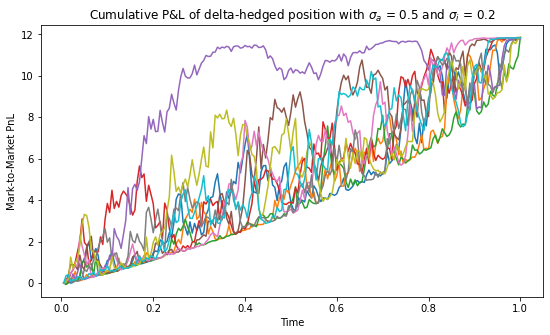

In [123]:
plt.figure(figsize=(9,5))
plt.plot(df_mtm_ytd)
plt.title('Cumulative P&L of delta-hedged position with $\sigma_a$ = 0.5 and $\sigma_i$ = 0.2')
plt.xlabel('Time')
plt.ylabel('Mark-to-Market PnL')
plt.show()

#### 1.2 Key takeaways:
> - Final profit is deterministic equal to $\sigma_a - \sigma_i$
> - Daily profit is not guranteed due to randomness $dX$
> - Changes in S would not cancel out with option value changes, which is not favorable from risk mgmt perspective.
> - In reality, realized volatility cannot be known in advance for hedging
> - There seems to be upper and lower bounds of the PnL
> 


#### 1.3 Boudaries

As shown above, MtM profit is:
$$dV^i-dV^a-r(V^i-V^a)dt = e^{rt}d[e^{-rt}(V^i - V^a)]$$

Integrating from the inception time $t_0$ to a time at $t_m$, where stock price arrives at $S_0$ and $S_m$, respectively:

\begin{equation}
e^{rt_0} \int_{t_0}^{t_m} d[e^{-rt} (V^i - V^a)]
= e^{rt_0} [e^{-rt_m}(V^{i,m} - V^{a,m}) - e^{-rt_0}(V^{i,0} - V^{a,0})]
= (V^{a,0} - V^{i,0}) - e^{-r(t_m-t_0)}(V^{a,m} - V^{i,m})
\end{equation}

If $\sigma^a > \sigma^i$, $V^a > V^i$ given that vanila option prices are monotonically increasing in volatility. Hence, the upper bound occurs when the second term is 0, i.e. stock price at time m is 0 or $\infin$ independent of volatility. The upper bound is the constant value: $$V^{a,0} - V^{i,0}$$ 

The lower bound is given by differentiating the second term with respect to stock price and setting the derivative to 0 to obtain the maximum, at which the lower bound is: $$(V^{a,0} - V^{i,0}) - 2Ke^{-rdt}[N(\frac{1}{2}(\sigma^a - \sigma^i)\sqrt{dt}-\frac{1}{2})]$$

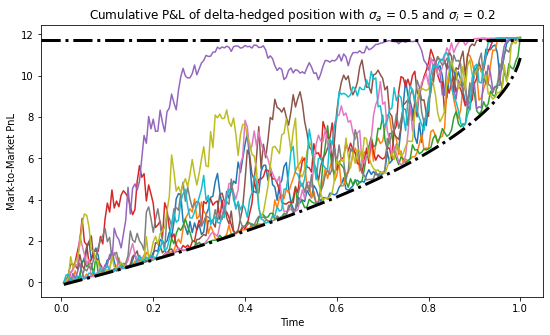

In [91]:
plt.figure(figsize=(9,5))
plt.plot(df_mtm_ytd)
plt.axhline(upper_bound.values[0], color='black', linestyle='-.',linewidth=3)
plt.plot(lower_bound, color='black', linestyle='-.',linewidth=3)
plt.title('Cumulative P&L of delta-hedged position with $\sigma_a$ = 0.5 and $\sigma_i$ = 0.2')
plt.xlabel('Time')
plt.ylabel('Mark-to-Market PnL')
plt.show()

#### 2. Delta hedging with implied volatility

In doing delta hedges with implied volatility, the option price change resulted from stochastice change in stock price would cancel out with the value of shares position determined by the delta computed at same implied volatility.   

The profit would be:

$$\text{dPnL} = dV^i - rV^idt - \Delta^idS + (r-q)\Delta^iSdt$$

Applying Ito's lemma:


$$=\Theta^i dt + \Delta^i dS + \frac{1}{2} \Gamma^i\sigma^2S^2dt - rV^i dt -\Delta^i dS +(r-q)\Delta^iSdt$$
$$=\Theta^i dt + \frac{1}{2} \Gamma^i\sigma^2S^2dt - rV^i dt +(r-q)\Delta^iSdt$$

where $rV^idt = \Theta^idt+(r-q)\Delta^iSdt+\frac{1}{2}\Gamma^i\tilde\sigma^2S^2dt$

plug in above formula, we will have:

$$\text{dPnL}=\frac{1}{2}\Gamma^i S^2 (\sigma^2-\tilde \sigma^2)dt$$

Cumulative profit is obtained by integrating prior euqation:

$$PV[PnL] = \frac{1}{2} \int_{t_0}^{T}e^{-rt} \cdot \Gamma^i S^2 (\sigma^2-\tilde\sigma^2) dt$$


In [9]:
def implied_delta_hedged_ptf(S0, strike_price, rf, mu, q, sigma_actual,sigma_implied, T, dt, n_scenarios=1):
    
    day = int(datetime.datetime.today().strftime('%d'))
    month = int(datetime.datetime.today().strftime('%m'))
    year = int(datetime.datetime.today().strftime('%Y'))
    
    # Get the option start and expiry date
    valuation_date = Date(day, month, year)
    expiry_date = valuation_date.add_years(T)
    
    n_steps = int(T/dt)

    valuation_spot_dates = valuation_date.add_years(np.linspace(dt,T,n_steps-1))
    valuation_spot_dates.insert(0,valuation_date)
    
    #set up BSM model
    call_option = EquityVanillaOption(expiry_date,strike_price,OptionTypes.EUROPEAN_CALL)    
    model_implied = BlackScholes(sigma_implied)

    
    #GBM simulation
    S_t_path = gbm(S0, mu, sigma_actual, T, dt, n_scenarios)   

    df_call_option_value_implied = pd.DataFrame()
    df_call_option_delta_implied = pd.DataFrame()
    
    for i in range(len(valuation_spot_dates)):
        discount_curve = DiscountCurveFlat(valuation_spot_dates[i],rf,FrequencyTypes.CONTINUOUS)
        dividend_curve = DiscountCurveFlat(valuation_spot_dates[i],q)
        call_option_value_implied = call_option.value(valuation_spot_dates[i],S_t_path.loc[i],discount_curve,dividend_curve,model_implied)
        call_option_delta_implied = call_option.delta(valuation_spot_dates[i],S_t_path.loc[i],discount_curve,dividend_curve,model_implied)  


        df_call_option_value_implied = pd.concat([df_call_option_value_implied,call_option_value_implied],axis=1)
        df_call_option_delta_implied = pd.concat([df_call_option_delta_implied,call_option_delta_implied],axis=1)   
    
    df_call_option_value_implied = df_call_option_value_implied.T
    df_call_option_delta_implied = df_call_option_delta_implied.T
    
    d_option_value_implied =  df_call_option_value_implied.diff()
    d_stock_value = pd.DataFrame(S_t_path).diff()
    
    d_option_value_implied=d_option_value_implied.fillna(0)
    d_stock_value=d_stock_value.fillna(0)

    daily_mtm_pnl = -1*(d_option_value_implied- df_call_option_delta_implied*d_stock_value - mu*(df_call_option_value_implied-df_call_option_delta_implied*S_t_path)*dt - df_call_option_delta_implied*q*S_t_path*dt)
    
    ytd_mtm_pnl = daily_mtm_pnl.cumsum()
    ytd_mtm_pnl.index = np.linspace(dt,T,n_steps)
    
    return S_t_path,d_stock_value,df_call_option_value_implied,df_call_option_delta_implied,d_option_value_implied,daily_mtm_pnl,ytd_mtm_pnl

In [111]:
n_scenarios = 5
df_mtm_ytd_imp = pd.DataFrame()
df_s_path = pd.DataFrame()

for i in range(n_scenarios):
    q=implied_delta_hedged_ptf(100, 100, 0.01, 0.01, 0.001,0.5,0.2,1,0.005,1)
    df_s_path = pd.concat([df_s_path,q[0]],axis=1)
    df_mtm_ytd_imp = pd.concat([df_mtm_ytd_imp,q[-1]],axis=1)

In [117]:
df_s_path.index = df_mtm_ytd_imp.index

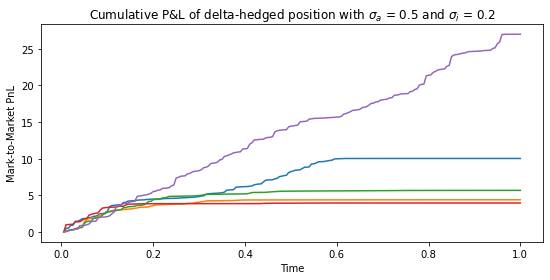

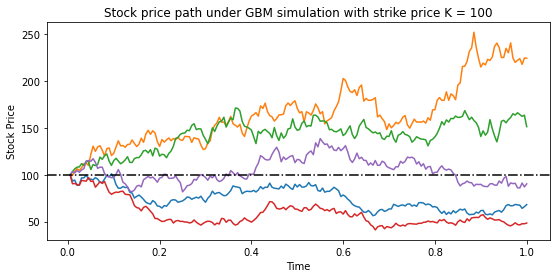

In [125]:
plt.figure(figsize=(9,4))
plt.plot(df_mtm_ytd_imp)
plt.title('Cumulative P&L of delta-hedged position with $\sigma_a$ = 0.5 and $\sigma_i$ = 0.2')
plt.xlabel('Time')
plt.ylabel('Mark-to-Market PnL')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(df_s_path)
plt.axhline(100, color='black', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock price path under GBM simulation with strike price K = 100')
plt.show()

#### 2.1 Key takeaways
> - Daily PnL is deterministic without random term
> - Final PnL is path dependent not deterministic
> - $\Gamma_i S^2$ will be close to 0 if option is deep in- or out- of money and hedging strategy would be insensitive to volatility
> - Total profit would be maximized if stock price ends up close to strike at maturity (*refer to **violet** trajactory in above figures*)
> - No need to forecast $\sigma_a$ accurately to make profits but only need to estimate the sign of $(\sigma_a^2-\sigma_i^2)$
>

#### 2.2. Generalized case of hedging with $\sigma^h$

It can be shown that if we buy an option with implied volatility and hedged with volatility $\sigma^h$ which is not necessarily the observable realized volatility, the PnL over time to expiration would be:

$$
\text{PnL} = V^h - V^i + \frac{1}{2} \int_{t_0}^{T} e^{-r(t-t_0)} \Gamma^hS^2(\sigma_r^2 - \sigma_h^2)dt
$$